In [2]:
# 1) Create a list of rate constants
# 2) Run solve_ivp and obtain differential equations
# 3) Extract concentrations of A and B monomers


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from PenultimateFRP import CopolymerizationModel
%load_ext autoreload
%autoreload 2

In [4]:
# Initiation rate constant
kd    = 3e-06 
f     = 0.5

# Propagation rate constants
kpAA = 2.0e+04
kpAB = 5.0e+04
kpBA = 4.0e+02
kpBB = 8.0e+02

# Depropagation rate constants
kdAA = 1e-5
kdAB = 1e-5
kdBA = 1e-5
kdBB = 1e-5
kdf = 0.5
# kdAA = kdf*kpAA
# kdAB = kdf*kpAB
# kdBA = kdf*kpBA
kdBB = kdf*kpBB

# Termination by combination rate constants
ktcAA = 2*1.5e+08
ktcAB = 2*5.0e+07
ktcBB = 2*1.5e+07
ktcAA = 1e-5
ktcAB = 1e-5
ktdBB = 1e-5

# Termination by disproportionation rate constants
ktdAA = 2*9.0e+06     
ktdAB = 2*1.5e+07
ktdBB = 2*2.0e+07

k = [kd, f, 
     kpAA, kpAB, kpBA, kpBB, 
     kdAA, kdAB, kdBA, kdBB,
     ktcAA, ktcAB, ktcBB,
     ktdAA, ktdAB, ktdBB]

# Define initial concentrations
I0 = 0.005
A0 = 0.9
B0 = 2.1
CA_final = A0 / (A0 + B0)
CB_final = B0 / (A0 + B0)

y0 = np.zeros(33)
y0[0] = I0
y0[2] = A0
y0[3] = B0

num_points = 40
t_span = [0, 60*3600]
t = np.linspace(t_span[0], t_span[1], num_points)

In [5]:
def func(t, *k): 
    cm = CopolymerizationModel(k, y0, t_span)
    return cm.A

def func_wrapper(t, *k):
    k_modified = list(k)
    k_modified[6] = 0
    cm = CopolymerizationModel(k_modified, y0, t_span)
    return cm.A

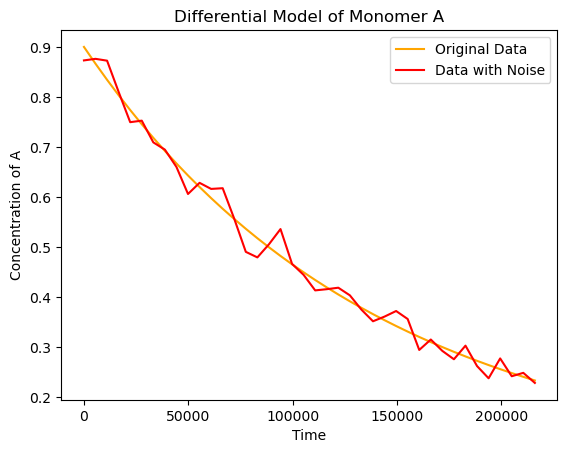

In [6]:
y = func_wrapper(t, *k)
rng = np.random.default_rng()
y_noise = 0.02 * rng.normal(size=t.size)
y_exp = y + y_noise
plt.plot(t, y, 'orange', label='Original Data')
plt.plot(t, y_exp, 'r', label='Data with Noise')

plt.xlabel('Time')
plt.ylabel('Concentration of A')
plt.title('Differential Model of Monomer A')
plt.legend()

In [7]:
k_true = np.array(k)
k_ub = 2*k_true
k_lb = np.zeros_like(k_ub)

array([6.0e-06, 1.0e+00, 4.0e+04, 1.0e+05, 8.0e+02, 1.6e+03, 2.0e-05,
       2.0e-05, 2.0e-05, 8.0e+02, 2.0e-05, 2.0e-05, 6.0e+07, 3.6e+07,
       6.0e+07, 8.0e+07])

In [8]:
k_guess = np.array([10**np.floor(np.log10(val)) for val in k_true])
k_guess

array([1.e-06, 1.e-01, 1.e+04, 1.e+04, 1.e+02, 1.e+02, 1.e-05, 1.e-05,
       1.e-05, 1.e+02, 1.e-05, 1.e-05, 1.e+07, 1.e+07, 1.e+07, 1.e+07])

In [9]:
popt_true, pcov_true = curve_fit(func_wrapper, t, y_exp, bounds=(k_lb, k_ub), p0=k_true)
popt_true

array([2.99338445e-06, 4.99999990e-01, 2.00000000e+04, 5.00000000e+04,
       4.00000000e+02, 8.00000000e+02, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 4.00000000e+02, 1.00000000e-05, 1.00000000e-05,
       3.00000000e+07, 1.80000000e+07, 3.00000000e+07, 4.00000000e+07])

In [10]:
popt_guess, pcov_guess = curve_fit(func, t, y_exp, bounds=(k_lb, k_ub), p0=k_guess)
popt_guess


array([1.95434962e-06, 2.93628637e-01, 1.57738304e+04, 8.71327912e+03,
       2.17897734e+02, 3.38165198e+02, 1.57345495e-05, 1.56008340e-05,
       1.64522679e-05, 6.31985817e+01, 1.36188635e-05, 1.83555380e-05,
       8.70660219e+06, 4.15353090e+05, 1.02269793e+07, 9.24883569e+06])

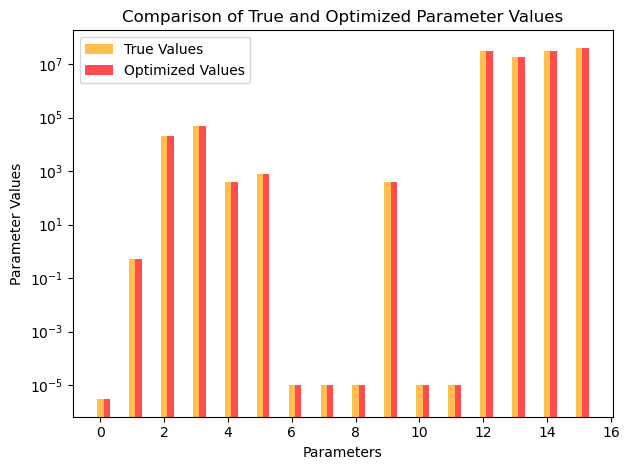

In [11]:
bar_width = 0.2
index = np.arange(len(k_true))

# Plot the true values (in blue) and the optimized values (in red)
plt.bar(index, k_true, bar_width, label='True Values', color='orange', alpha=0.7)
plt.bar(index + bar_width, popt_true, bar_width, label='Optimized Values', color='red', alpha=0.7)
plt.yscale("log")

# Customize the plot
plt.xlabel('Parameters')
plt.ylabel('Parameter Values')
plt.title('Comparison of True and Optimized Parameter Values')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Look at other methods of optimization in scipy.optimize.curve_fit
# Loosen the bounds
# What if there's a rate constant we don't want to fit?
# Try shrinking down the number of rate constants being fit

$\text{Static Constants}$

$\text{Varying Optimization Methods}$

In [13]:
popt_trf, pcov_trf = curve_fit(func, t, y_exp, bounds=(0, k_ub), p0=k_guess, method='trf')
popt_dogbox, pcov_dogbox = curve_fit(func, t, y_exp, bounds=(0, k_ub), p0=k_guess, method='dogbox')

print("trf ", popt_trf)
print("dogbox ", popt_dogbox)

KeyboardInterrupt: 

In [ ]:
residual_trf = popt_true - popt_trf
residual_norm_trf = np.linalg.norm(residual_trf, ord=2)

residual_dogbox = popt_true - popt_dogbox
residual_norm_dogbox = np.linalg.norm(residual_dogbox, ord=2)

if (residual_norm_trf > residual_norm_dogbox):
    print("residual norm trf: ", residual_norm_trf, "residual norm dogbox:", residual_norm_dogbox)
    print("dogbox is a more accurate optimization method than trf")
else:
    print("trf is a more accurate optimization method than dogbox")



residual norm trf:  63843588.305642925 residual norm dogbox: 63843588.305575654
dogbox is a more accurate optimization method than trf


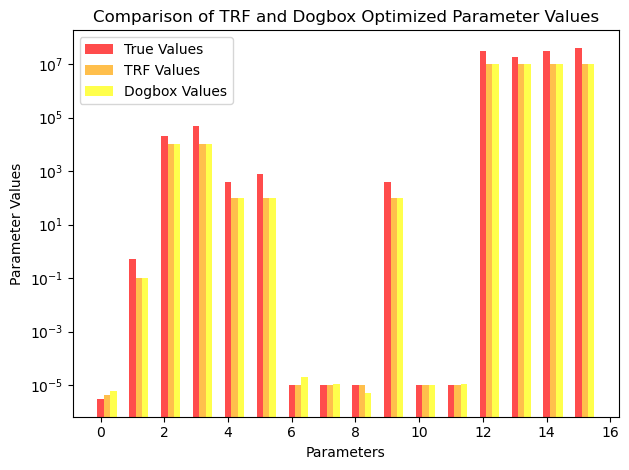

In [ ]:
bar_width = 0.2
index = np.arange(len(k_true))

# Plot the true values (in blue) and the optimized values (in red)
plt.bar(index, k_true, bar_width, label='True Values', color='red', alpha=0.7)
plt.bar(index + bar_width, popt_trf, bar_width, label='TRF Values', color='orange', alpha=0.7)
plt.bar(index + bar_width*2, popt_dogbox, bar_width, label='Dogbox Values', color='yellow', alpha=0.7)
plt.yscale("log")

# Customize the plot
plt.xlabel('Parameters')
plt.ylabel('Parameter Values')
plt.title('Comparison of TRF and Dogbox Optimized Parameter Values')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()